<a href="https://www.kaggle.com/code/pawankumargunjan/toxic-comment-classification?scriptVersionId=138292481" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
import re
from wordcloud import WordCloud, STOPWORDS

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

import os
import zipfile
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning:

unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning:

file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-

# Load the Dataset

In [2]:
kaggle_input_path = '/kaggle/input/jigsaw-toxic-comment-classification-challenge'

files_in_directory = os.listdir(kaggle_input_path)
print(files_in_directory)


for file_name in files_in_directory:
    # Skip non-zip files if any
    if not file_name.endswith('.zip'):
        continue

    # Path to the zip file
    zip_file_path = os.path.join(kaggle_input_path, file_name)

    # Directory where you want to extract the contents
    output_dir = '/kaggle/working/'

    # Unzip the file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
        # Print complete paths of the extracted files
        extracted_files = zip_ref.namelist()
        for extracted_file in extracted_files:
            complete_path = os.path.join(output_dir, extracted_file)
            print("Extracted:", complete_path)

['train.csv.zip', 'sample_submission.csv.zip', 'test_labels.csv.zip', 'test.csv.zip']
Extracted: /kaggle/working/train.csv
Extracted: /kaggle/working/sample_submission.csv
Extracted: /kaggle/working/test_labels.csv
Extracted: /kaggle/working/test.csv


In [3]:
train = pd.read_csv("/kaggle/working/train.csv")
train.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
125400,9ebee952f6136608,Name\n| Occupation\n| Likes\n|-\n| Aaron Virdi...,0,0,0,0,0,0
5497,0ea265286b32d160,"""==Request for Usurpation==\n\nHello, JOptionP...",0,0,0,0,0,0
149950,642aaa96aa411661,Cheers for the heads up - and thanks for fixin...,0,0,0,0,0,0
131291,be77246d47079c00,"""\n\n 100 point game \n\nI think you are a mor...",0,0,0,0,1,0
21361,384f62cf34115134,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0


In [4]:
test = pd.read_csv("/kaggle/working/test.csv")
test.sample(3)

,id,comment_text
20837,22de9fc8d4842572,""" \n\n ::::: I agree with that the second mea..."
126451,d34452c5ccf65493,:이해 할 수 없는 이유입니다. 그 사진이 잘찍은 사진이 아니라는 건 다분히 님의 ...
103284,ac67c61b36735cf6,I'm wondering if perhaps the women in private ...


In [5]:
submission = pd.read_csv("/kaggle/working/sample_submission.csv")
submission.sample(3)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
29589,313674d66180cab7,0.5,0.5,0.5,0.5,0.5,0.5
103542,acdc5eb8a63cf9e4,0.5,0.5,0.5,0.5,0.5,0.5
100231,a73f869caffc5330,0.5,0.5,0.5,0.5,0.5,0.5


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


# Preprocessing

In [7]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove web links
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove special characters, punctuation marks, and numbers
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Insert spaces between certain patterns (e.g., "ie", "eg")
    text = re.sub(r'(\s)([iI][eE]|[eE][gG])(\s)', r' \2 ', text)

    # Remove extra white spaces
    text = " ".join(text.split())

    return text.lower()

# Example usage with the provided text
texts = [
    "\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of 'types of accidents'  -I think the references may need tidying so that they are all in the exact same format ie date format etc I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport"
]

cleaned_texts = [clean_text(text) for text in texts]
print(cleaned_texts)

['more i can t make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up it s listed in the relevant form eg wikipedia good article nominations transport']


## Data Visualization to Understand Class Distribution

In [9]:
train['Cleaned_Comments'] = train['comment_text'].apply(clean_text)
train['Cleaned_Comments'].head()

0    explanation why the edits made under my userna...
1    d aww he matches this background colour i m se...
2    hey man i m really not trying to edit war it s...
3    more i can t make any real suggestions on impr...
4    you sir are my hero any chance you remember wh...
Name: Cleaned_Comments, dtype: object

In [10]:
# Function to generate word cloud
def generate_wordcloud(text,Title):
    wordcloud = WordCloud(width=800, height=400,stopwords=set(STOPWORDS), background_color='black').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(Title)
    plt.show()

In [11]:
target_labels= [col for col in train.columns if train[col].dtypes == 'int64']
target_labels

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

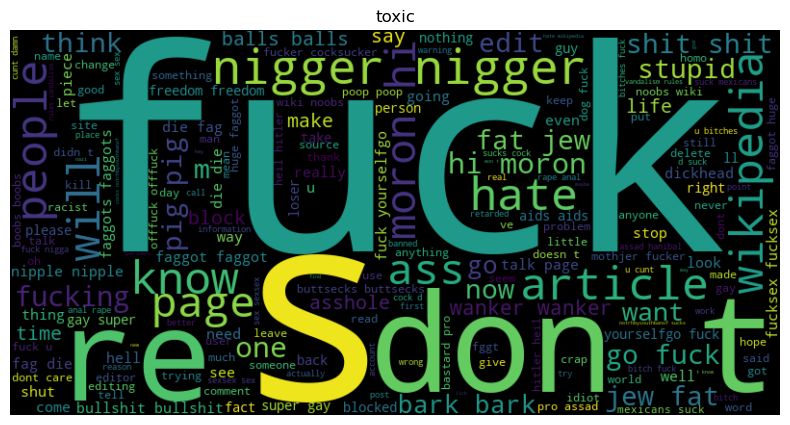

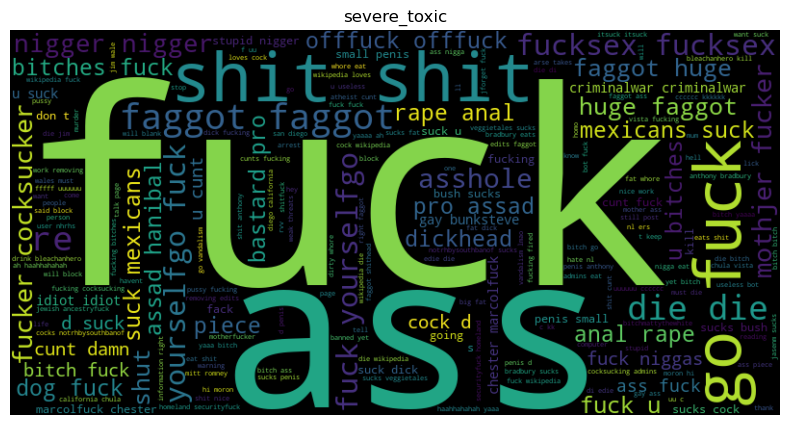

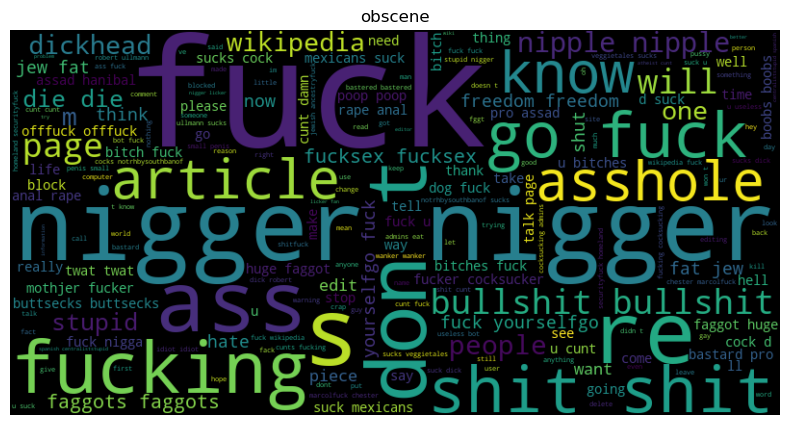

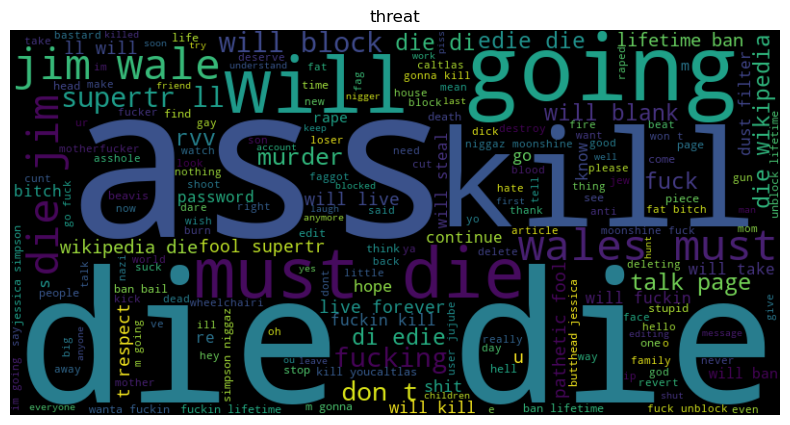

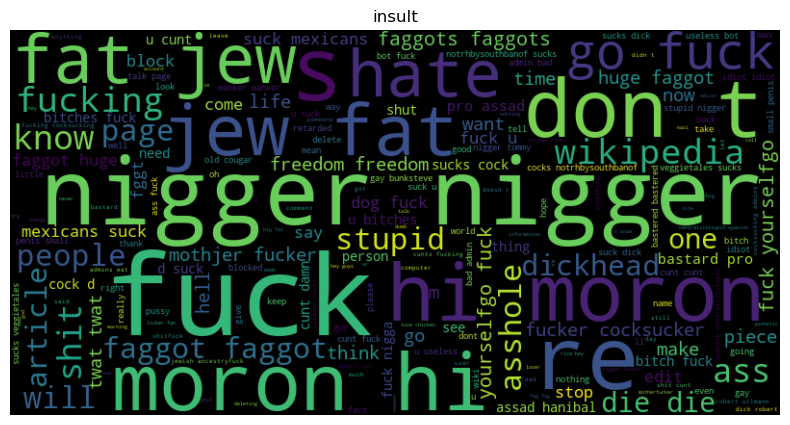

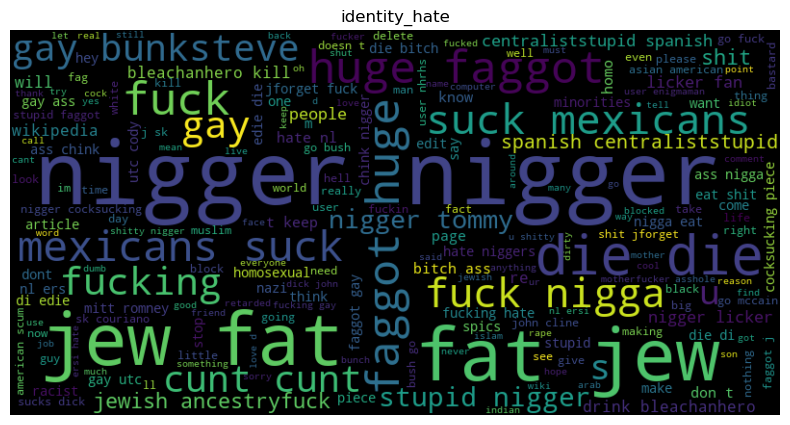

In [12]:
# Plot word clouds for each target label
for label in target_labels:
    text = ' '.join(train[train[label] == 1]['Cleaned_Comments'].values)
    generate_wordcloud(text,Title=label)

In [13]:
comments=train['Cleaned_Comments'].to_list()
comments[:5]

['explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now',
 'd aww he matches this background colour i m seemingly stuck with thanks talk january utc',
 'hey man i m really not trying to edit war it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info',
 'more i can t make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there ap

In [14]:
train[target_labels].sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [15]:
# Calculate the value counts for each target label
value_counts = train[target_labels].sum()

# Add the count for the "neither" category (where all target labels are 0)
value_counts['Good Comments'] = len(train) - value_counts.sum()

fig =px.bar(x= value_counts.index,
            y= value_counts.values,
            color=value_counts.index,
            color_discrete_sequence =  px.colors.qualitative.Dark24_r,
            title='<b>Counts of Target Labels')

fig.update_layout(title='Counts of Target Labels',
                  xaxis_title='Toxicity Labels',
                  yaxis_title='Counts',
                  template='plotly_dark')

# Show the bar chart
fig.show()
pyo.plot(fig, filename = 'Counts of Target Labels.html', auto_open = True)

'Counts of Target Labels.html'

# Split the dataset into Train, Test and Validation

In [16]:
# Split data into training, testing sets & validation sets 
Train_texts, Test_texts, Train_labels, Test_labels = train_test_split(
    comments, train[target_labels].values, test_size=0.3, random_state=23)

#validation set
test_texts, val_texts, test_labels, val_labels = train_test_split(
    Test_texts, Test_labels, test_size=0.5, random_state=23)

print('Training Dataset -->',len(Train_texts), Train_labels.shape)
print('Testing Dataset -->',len(test_texts), test_labels.shape)
print('Training Dataset -->',len(val_texts), val_labels.shape)

Training Dataset --> 111699 (111699, 6)
Testing Dataset --> 23936 (23936, 6)
Training Dataset --> 23936 (23936, 6)


# Fine-tune BERT Model for Multilabel Classification

#### Tokenization & encoding using BertTokenizer

In [17]:
def tokenize_and_encode(tokenizer, comments, labels, max_length=128):
    # Initialize empty lists to store tokenized inputs and attention masks
    input_ids = []
    attention_masks = []

    # Iterate through each comment in the 'comments' list
    for comment in comments:
        # Tokenize and encode the comment using the BERT tokenizer
        encoded_dict = tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Append the tokenized input and attention mask to their respective lists
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists of tokenized inputs and attention masks to PyTorch tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    # Convert the labels to a PyTorch tensor with the data type float32
    labels = torch.tensor(labels, dtype=torch.float32)

    # Return the tokenized inputs, attention masks, and labels as PyTorch tensors
    return input_ids, attention_masks, labels

In [18]:
# Token Initialization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Model Initialization
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [19]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

model =model.to(device)

cuda


In [20]:
# Tokenize and Encode the comments and labels for the training set
input_ids, attention_masks, labels = tokenize_and_encode(
    tokenizer, 
    Train_texts, 
    Train_labels
)

# Step 4: Tokenize and Encode the comments and labels for the test set
test_input_ids, test_attention_masks, test_labels = tokenize_and_encode(
    tokenizer,
    test_texts,
    test_labels
)

# Tokenize and Encode the comments and labels for the validation set
val_input_ids, val_attention_masks, val_labels = tokenize_and_encode(
    tokenizer,
    val_texts,
    val_labels
)

print('Training Comments :',len(Train_texts))
print('Input Ids         :',input_ids.shape)
print('Attention Mask    :',attention_masks.shape)
print('Labels            :',labels.shape)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Training Comments : 111699
Input Ids         : torch.Size([111699, 128])
Attention Mask    : torch.Size([111699, 128])
Labels            : torch.Size([111699, 6])


In [21]:
k = 523
print('Training Comments -->>',Train_texts[k])
print('\nInput Ids -->>\n',input_ids[k])
print('\nDecoded Ids -->>\n',tokenizer.decode(input_ids[k]))
print('\nAttention Mask -->>\n',attention_masks[k])
print('\nLabels -->>',labels[k])

Training Comments -->> suppression of irish history the bobby sands article shows that wikipedia has an anti irish bias because it allows an anti irish bigot like

Input Ids -->>
 tensor([  101, 16341,  1997,  3493,  2381,  1996,  6173, 13457,  3720,  3065,
         2008, 16948,  2038,  2019,  3424,  3493, 13827,  2138,  2009,  4473,
         2019,  3424,  3493,  2502,  4140,  2066,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     

## Creating DataLoaders for training dataset

In [22]:
# Creating DataLoader for the balanced dataset
batch_size = 32
train_dataset = TensorDataset(input_ids, attention_masks, labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#test
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#val
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [23]:
print('Batch Size :',train_loader.batch_size)
Batch =next(iter(train_loader))
print('Each Input ids shape :',Batch[0].shape)
print('Input ids :\n',Batch[0][0])
print('Corresponding Decoded text:\n',tokenizer.decode(Batch[0][0]))
print('Corresponding Attention Mask :\n',Batch[1][0])
print('Corresponding Label:',Batch[2][0])

Batch Size : 32
Each Input ids shape : torch.Size([32, 128])
Input ids :
 tensor([  101,  3374,  2057,  2222,  2196,  3113,  9986,  2045,  1055,  2042,
         3112,  1998,  4945,  1996,  3112,  2003,  2008,  2045,  2003, 26047,
         3258,  2006,  1996,  2831,  3931,  2005,  1996,  6440,  7051, 16012,
         1998,  2009,  1055,  4208,  1045,  2156,  2111,  9085,  2830,  2000,
         2360,  1996,  2477,  2008,  2342,  2022,  2056,  1998,  2000,  2811,
         2005,  6998,  2000,  4189,  3980,  2000,  2216,  2007, 10078, 21386,
         2015,  1996,  4945,  3383,  3904,  1037,  8688,  2018,  2000,  2022,
         2081,  2021,  2017,  2354,  2008,  2183,  1999,  1998,  2017,  2354,
         1045,  2354,  1998,  2077,  1996,  2089,  4875,  7615,  2017,  2024,
         6047,  9986,  1998, 12266,  2123,  1056,  2425,  2033,  2129,  2009,
         2035,  2573,  2041,  1999,  5083,  1045,  2933,  2000,  3422,  2111,
         2147,  2009,  2041,  2004,  2009, 22901,  2123,  1056, 2759

### Initialising optimizer
Initializes the optimizer for training the model 

Adam with Weight Decay (AdamW) is a variant of the Adam optimizer that incorporates weight decay (L2 regularization) during the parameter updates. It is an extension of the original Adam optimizer and addresses some of its limitations when using weight decay as a regularization technique.

In [24]:
# Optimizer setup
optimizer = AdamW(model.parameters(), lr=0.00002)

# Model training 

In [25]:
def train_model(model, train_loader, val_loader, optimizer, device, num_epochs):
    # Loop through the specified number of epochs
    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train() 
        # Initialize total loss for the current epoch
        total_loss = 0  

        # Loop through the batches in the training data
        for batch in train_loader:
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        model.eval()  # Set the model to evaluation mode
        val_loss = 0

        # Disable gradient computation during validation
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [t.to(device) for t in batch]

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()

        # Print the average loss for the current epoch
        print(f'Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}')

# Assuming you have 'train_loader' and 'val_loader' defined elsewhere
# Call the function to train the model
train_model(model, train_loader, val_loader, optimizer, device, num_epochs=3)

Epoch 1, Training Loss: 0.053285288232735074, Validation Loss: 0.041396142783846186
Epoch 2, Training Loss: 0.03490501133032691, Validation Loss: 0.03738276289345169
Epoch 3, Training Loss: 0.02755988560507691, Validation Loss: 0.04157150729899737


# Model Evaluation 

In [26]:
# Evaluate the Model
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode

    true_labels = []
    predicted_probs = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            # Get model's predictions
            outputs = model(input_ids, attention_mask=attention_mask)
            predicted_probs_batch = torch.sigmoid(outputs.logits)  # Use sigmoid for multilabel classification
            predicted_probs.append(predicted_probs_batch.cpu().numpy())

            true_labels_batch = labels.cpu().numpy()
            true_labels.append(true_labels_batch)

    # Combine predictions and labels for evaluation
    true_labels = np.concatenate(true_labels, axis=0)
    predicted_probs = np.concatenate(predicted_probs, axis=0)
    predicted_labels = (predicted_probs > 0.5).astype(int)  # Apply threshold for binary classification

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='micro')
    recall = recall_score(true_labels, predicted_labels, average='micro')

    # Print the evaluation metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')

# Call the function to evaluate the model on the test data
evaluate_model(model, test_loader, device)

Accuracy: 0.9265
Precision: 0.8084
Recall: 0.7743


## Save the model

In [27]:
# Save the tokenizer and model in the same directory
output_dir = "/kaggle/working/Saved_model"
model.save_pretrained(output_dir)  # Save model's state dictionary and configuration
tokenizer.save_pretrained(output_dir)  # Save tokenizer's configuration and vocabulary

('/kaggle/working/Saved_model/tokenizer_config.json',
 '/kaggle/working/Saved_model/special_tokens_map.json',
 '/kaggle/working/Saved_model/vocab.txt',
 '/kaggle/working/Saved_model/added_tokens.json')

## Load the model

In [28]:
# Load the tokenizer and model from the saved directory
model_name ="/kaggle/working/Saved_model"
Bert_Tokenizer = BertTokenizer.from_pretrained(model_name)
Bert_Model = BertForSequenceClassification.from_pretrained(model_name).to(device)

# Prediction for user input

In [29]:
def predict_user_input(input_text, model=Bert_Model, tokenizer=Bert_Tokenizer,device=device):
    user_input = [input_text]

    user_encodings = tokenizer(user_input, truncation=True, padding=True, return_tensors="pt")

    user_dataset = TensorDataset(user_encodings['input_ids'], user_encodings['attention_mask'])

    user_loader = DataLoader(user_dataset, batch_size=1, shuffle=False)

    model.eval()
    with torch.no_grad():
        for batch in user_loader:
            input_ids, attention_mask = [t.to(device) for t in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.sigmoid(logits)

    predicted_labels = (predictions.cpu().numpy() > 0.5).astype(int)
    return predicted_labels[0].tolist()

In [30]:
text = 'Are you insane!'
predict_user_input(input_text=text)

[1, 0, 0, 0, 0, 0]

In [31]:
predict_user_input(input_text='How are you?')

[0, 0, 0, 0, 0, 0]

In [32]:
input_text = 'You are insane'
predict_user_input(input_text)

[1, 0, 0, 0, 1, 0]

In [33]:
text = "Such a Idiot person"
predict_user_input(model=Bert_Model, 
                   tokenizer=Bert_Tokenizer,
                   input_text=text, 
                   device=device)

[1, 0, 1, 0, 1, 0]

In [34]:
text = "I'll kill you"
predict_user_input(model=Bert_Model, 
                   tokenizer=Bert_Tokenizer,
                   input_text=text, 
                   device=device)

[1, 0, 0, 1, 0, 0]

In [35]:
text = "I'll kill you"
predict_user_input(model=Bert_Model, 
                   tokenizer=Bert_Tokenizer,
                   input_text=text, 
                   device=device)

[1, 0, 0, 1, 0, 0]

# Submission

In [36]:
test['Cleaned_Comments'] = test['comment_text'].apply(clean_text)

In [37]:
test_labels = pd.read_csv("/kaggle/working/test_labels.csv")
test_labels.head(3)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1


In [38]:
test_labels[target_labels]=test['Cleaned_Comments'].apply(predict_user_input).tolist()
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,1,1,1,0,1,1
1,0000247867823ef7,0,0,0,0,0,0
2,00013b17ad220c46,0,0,0,0,0,0
3,00017563c3f7919a,0,0,0,0,0,0
4,00017695ad8997eb,0,0,0,0,0,0


In [39]:
submission = test[labels_list]
submission.to_csv('Sample_Submission.csv')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508 in run_code        │
│                                                                                                  │
│   3505 │   │   │   │   if async_:                                                                │
│   3506 │   │   │   │   │   await eval(code_obj, self.user_global_ns, self.user_ns)               │
│   3507 │   │   │   │   else:                                                                     │
│ ❱ 3508 │   │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                     │
│   3509 │   │   │   finally:                                                                      │
│   3510 │   │   │   │   # Reset our crash handler in place                                        │
│   3511 │   │   │   │   sys.excepthook = old_excepthook                                           │
│                                                                                                  │
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 submission = test[labels_list]                                                               │
│   2 submission.to_csv('Sample_Submission.csv')                                                   │
│   3                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'labels_list' is not defined